### Model training

In [ ]:
import os
from sklearn.externals import joblib

HOME_DIR = os.curdir
DATA_DIR = os.path.join(HOME_DIR, "data")
MODEL_DIR = os.path.join(HOME_DIR, "model")

In [4]:
import pandas as pd
from tqdm import tqdm

pd.options.display.max_colwidth = 255
tqdm.pandas()

In [5]:
X_train = joblib.load(f"{DATA_DIR}/x_train.pkl")
X_test = joblib.load(f"{DATA_DIR}/x_test.pkl")
y_train = joblib.load(f"{DATA_DIR}/y_train.pkl")
y_test = joblib.load(f"{DATA_DIR}/y_test.pkl")
y_classes = joblib.load(f"{DATA_DIR}/y_classes.pkl")

In [4]:
%%time

from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(max_depth=5,
                               eta=0.2,
                               gamma=4,
                               min_child_weight=6,
                               subsample=0.8,
                               early_stopping_rounds=10,
                               num_round=200,
                               n_jobs=-1)

clf = OneVsRestClassifier(xgb_classifier)
clf.fit(X_train, y_train)

`XGBClassifier` takes way too long to train, so I switch to linear model using `SGDClassifier`.

In [28]:
%%time

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(n_jobs=-1)

clf = OneVsRestClassifier(sgd_classifier)
clf.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


CPU times: user 11h 37min 22s, sys: 19min 36s, total: 11h 56min 58s
Wall time: 2h 22min 10s


The time shown here is not accurate. It took around 5 hours to train the model (which actually contains 4,000 models, one model for each class) on a whopping `ml.m5.12xlarge` instance on AWS.

This posed a challenge to me on model tuning as this training alone would cost ~$15 already. We will first evaluate the model and see how it performs.

In [29]:
# save the model
joblib.dump(clf, f"{MODEL_DIR}/one_vs_rest_classifier.pkl")

['./model/one_vs_rest_classifier.pkl']

In [ ]:
clf = joblib.load(f"{MODEL_DIR}/one_vs_rest_classifier.pkl")

In [7]:
%%time

y_pred = clf.predict(X_test)

CPU times: user 1min 51s, sys: 2.07 s, total: 1min 53s
Wall time: 1min 54s


In [31]:
joblib.dump(y_pred, f"{MODEL_DIR}/y_pred.pkl")

['./model/y_pred.pkl']

### Model evaluation

#### Precision, recall, F-1 score

In [26]:
%%time

from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)

print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"fscore: {fscore}")
print(f"support: {support}")

precision: [0.87878788 0.61148649 0.         ... 0.88       0.82352941 1.        ]
recall: [0.57649092 0.15048846 0.         ... 0.57894737 0.17283951 0.27272727]
fscore: [0.69624217 0.24153461 0.         ... 0.6984127  0.28571429 0.42857143]
support: [1157 4811   59 ...   38   81   33]
CPU times: user 3min 16s, sys: 1min 7s, total: 4min 23s
Wall time: 4min 46s


/Users/foxanng/.pyenv/versions/3.6.5/envs/stack-overflow-questions-auto-tagger/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Hamming loss

In [ ]:
from sklearn.metrics import hamming_loss

hamming = []

for i, (test, pred) in enumerate(zip(y_test.T, y_pred.T)):
    hamming.append(hamming_loss(test, pred))

In [157]:
metric_df = pd.DataFrame(data=[precision, recall, fscore, hamming, support],
                         index=["Precision", "Recall", "F-1 score", "Hamming loss", "True count"],
                         columns=y_classes)

In [158]:
metric_df

,.htaccess,.net,.net-2.0,.net-3.5,.net-4.0,.net-4.5,.net-assembly,.net-core,2d,32-bit,...,zend-framework2,zeromq,zip,zk,zlib,zookeeper,zoom,zsh,zurb-foundation,zxing
Precision,0.878788,0.611486,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.880000,0.823529,1.000000
Recall,0.576491,0.150488,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.258065,0.000000,0.238095,0.000000,0.281250,0.00000,0.578947,0.172840,0.272727
F-1 score,0.696242,0.241535,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.410256,0.000000,0.384615,0.000000,0.439024,0.00000,0.698413,0.285714,0.428571
Hamming loss,0.002326,0.018174,0.000236,0.00044,0.000624,0.0003,0.000136,0.000108,0.000364,0.000084,...,0.000612,0.000092,0.000436,0.000064,0.000092,0.000092,0.00028,0.000076,0.000280,0.000096
True count,1157.000000,4811.000000,59.000000,110.00000,156.000000,75.0000,34.000000,27.000000,91.000000,21.000000,...,153.000000,31.000000,109.000000,21.000000,23.000000,32.000000,70.00000,38.000000,81.000000,33.000000


Just by a quick glance, we can see that the actual results for some tags are quite good, e.g. `.htaccess`, `zookeeper`, `zsh`. The overall results are not as good as expected is because there are a lot of tags that results in no prediction at all.

In [177]:
metric_df.loc[:, metric_df.columns.str.startswith(".net")]

,.net,.net-2.0,.net-3.5,.net-4.0,.net-4.5,.net-assembly,.net-core
Precision,0.611486,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000
Recall,0.150488,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000
F-1 score,0.241535,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000
Hamming loss,0.018174,0.000236,0.00044,0.000624,0.0003,0.000136,0.000108
True count,4811.000000,59.000000,110.00000,156.000000,75.0000,34.000000,27.000000


For example, consider the list of tags with `.net` in the name.
We can see that the reason that a lot of tags has no predictions, is because:
- they have too few examples in the dataset.
- they are being tagged for the main topic instead of the sub topics.

e.g. specific version of `.net` (e.g. `.net-2.0`, `.net-3.5`), or sub topics under `.net` (e.g. `.net-assembly`, `.net-core`). We can filter them out to see how the model actually performs for major tags.

Let's take a look at the top 10 tags:

In [163]:
top_ten_tags = ["javascript", "java", "c#", "php", "android", "jquery", "python", "html", "c++", "ios"]
metric_df[top_ten_tags]

,javascript,java,c#,php,android,jquery,python,html,c++,ios
Precision,0.827928,0.860739,0.861886,0.876108,0.952586,0.915800,0.904279,0.613877,0.911454,0.786137
Recall,0.345116,0.399799,0.298210,0.554698,0.735213,0.472226,0.587470,0.259817,0.484266,0.406237
F-1 score,0.487161,0.545993,0.443106,0.679303,0.829901,0.623136,0.712234,0.365107,0.632486,0.535667
Hamming loss,0.073044,0.060682,0.060250,0.041792,0.021791,0.035757,0.024501,0.042675,0.021659,0.026720
True count,25151.000000,22834.000000,20110.000000,19964.000000,18090.000000,15662.000000,12913.000000,11816.000000,9629.000000,9492.000000


In [164]:
import numpy as np
metric_df[top_ten_tags].apply(np.mean, axis=1)

Precision           0.851079
Recall              0.454305
F-1 score           0.585409
Hamming loss        0.040887
True count      16566.100000
dtype: float64

The metrics for the top 10 tags are actually pretty good. It is partly because they have a lot of samples (true count) in the dataset.

In [188]:
non_zero_metric_df = metric_df.loc[:, metric_df.loc["F-1 score"] > 0]

In [189]:
non_zero_metric_df.apply(np.mean, axis=1)

Precision         0.877573
Recall            0.422915
F-1 score         0.527627
Hamming loss      0.001262
True count      489.225806
dtype: float64

There are 930 tags with predictions from this model, and the hamming loss is 0.001262, which beats the benchmark (0.002779), which contains only the top 500 popular tags. So this model is capable of predicting more tags with a lower loss.

### Extra

Text(0, 0.5, 'Recall')

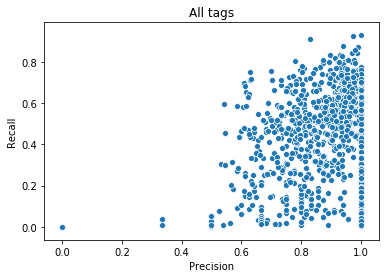

In [199]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=metric_df.loc["Precision"], y=metric_df.loc["Recall"])
plt.title("All tags")
plt.xlabel("Precision")
plt.ylabel("Recall")

Text(336.9714285714286, 0.5, 'Recall')

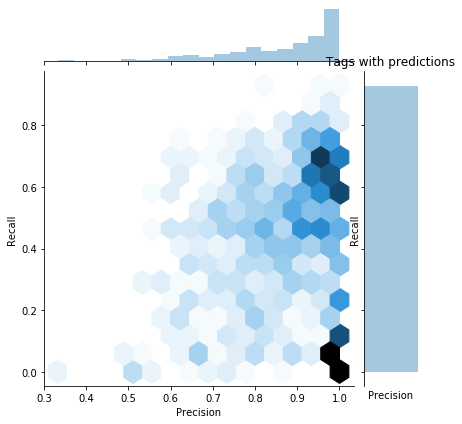

In [197]:
sns.jointplot(x=non_zero_metric_df.loc["Precision"], y=non_zero_metric_df.loc["Recall"], kind="hex")
plt.title("Tags with predictions")
plt.xlim((0, 1))
plt.xlabel("Precision")
plt.ylabel("Recall")

In [54]:
def print_pred_test_n(pred, test, n):
    pred_n = pd.DataFrame(y_pred[n:n+1], columns=y_classes)
    pred_n = pred_n.sum()
    print("Prediction:")
    print(pred_n[pred_n.values > 0])
    
    test_n = pd.DataFrame(y_test[n:n+1], columns=y_classes)
    test_n = test_n.sum()
    print("\nActual:")
    print(test_n[test_n.values > 0])

In [55]:
print_pred_test_n(y_pred, y_test, 100)

Prediction:
json    1
php     1
dtype: int64

Actual:
json     1
mysql    1
php      1
dtype: int64
